In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import numpy as np
import torch
import torch.nn as nn
import os
import signal
import cv2
import sys
import scipy.io as sio
import scipy
import imageio
import time
import skimage as sk
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from IPython.display import display, clear_output

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

from opticaltomography.forward_3dri import PhaseObject3D, TomographySolver
from opticaltomography.loss import mse_loss, sparsity_loss, total_variation_loss_2d, mse_loss_vec
import opticaltomography.opticsutils_3dri as utils
from opticaltomography.opticsutils_3dri import norm, norm_np, find_min_index, compute_psf_matrix_row

### **(MUST LOAD)** Basic Setting

In [3]:
# Units in um
wavelength = 0.519  # emission wl excited by 488 nm
n_measure = 1.33    # n of water
n_b = 1.33          # background
mag = 20            # 20x mag
pixel_size = 6.5    # pixel size = 6.5 um * 6.5 um      
na = 0.45
dx = pixel_size / mag  # pixel size = 6.5 um -> pixel size at the sample plane: 6.5 / 20 um
dy = dx
dz = dx * 3

t_f32 = torch.float32
t_c64 = torch.complex64
np_f32 = np.float32
np_c64 = np.complex64

In [4]:
# initial object, type: torch.float32
phantom = torch.zeros((200, 200, 25), dtype=t_f32)

# Set up ground truth object
phantom_coordinates = sio.loadmat("Dataset/phantomPoisson_nooverlap.mat")
phantom_temp = phantom_coordinates["phantomPoisson"]
phantom_obj = torch.ones_like(phantom) * 1.33 # set background
phantom_obj[50:150, 50:150, :] = phantom_obj[50:150, 50:150, :] + torch.from_numpy(phantom_temp) * 0.05 # ground truth
#solver_obj._x[50:150, 50:150, :] = torch.from_numpy(phantom_temp) * 0.1 # ground truth

### **(MUST LOAD)** Load USAF target

In [12]:
usaf = np.array(plt.imread('Dataset/usaf_s.jpeg'))
usaf = sk.color.rgb2gray(cv2.resize(usaf, (50, 50)))
usaf = np.where(usaf > 0.8, 1, 0)
usaf = np.pad(usaf, ((75, 75), (75, 75)), mode='constant', constant_values=0)

In [13]:
# indices to fy_illu and fx_illu
indices = (np.argwhere(usaf == 1) - 100) / 200
fy_illu_usaf = indices[:,0]
fx_illu_usaf = indices[:,1]
fz_illu_usaf = np.zeros_like(fy_illu_usaf)

In [14]:
solver_params = dict(wavelength = wavelength, na = na, \
                     RI_measure = n_measure, sigma = 2 * np.pi * dz / wavelength,\
                     fx_illu_list = fx_illu_usaf, fy_illu_list = fy_illu_usaf, fz_illu_list = fz_illu_usaf, \
                     voxel_size=(dy,dx,dz), pad = False, pad_size=(50,50))
phase_obj_3d = PhaseObject3D(shape=phantom.shape, voxel_size=(dy,dx,dz), RI_obj=phantom_obj, RI=n_b) # set phantom_obj as gt obj, n_b as background
solver_obj = TomographySolver(phase_obj_3d=phase_obj_3d, **solver_params)
solver_obj.setScatteringMethod(model="MultiPhaseContrast")  # select scattering model

In [15]:
forward_field_mb, fields = solver_obj.forwardPredict(obj=solver_obj._x)

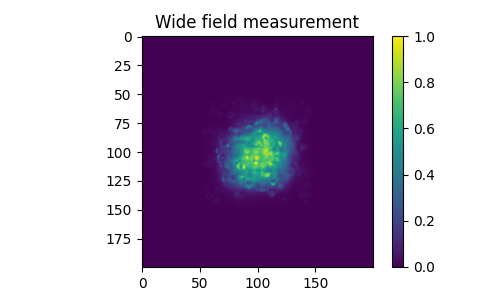

In [16]:
forward_total = norm(torch.sum(forward_field_mb, axis=0))
plt.figure(figsize=(5,3))
plt.imshow(forward_total)
plt.title('Wide field measurement')
plt.colorbar()

# Model-based spatially varying reconstruction

## Load data and set parameters

In [34]:
fy_varying = (np.arange(50, 150, 1) - 100) / 200
fx_varying = (np.arange(50, 150, 1) - 100) / 200

fy_varying, fx_varying = np.meshgrid(fy_varying, fx_varying)

fy_varying = fy_varying.reshape((-1,))
fx_varying = fx_varying.reshape((-1,))
fz_varying = np.zeros_like(fx_varying)

In [35]:
solver_params = dict(wavelength = wavelength, na = na, \
                     RI_measure = n_measure, sigma = 2 * np.pi * dz / wavelength,\
                     fx_illu_list = fx_varying, fy_illu_list = fy_varying, fz_illu_list = fz_varying, \
                     voxel_size=(dy,dx,dz), pad = False, pad_size=(50,50))
phase_obj_3d = PhaseObject3D(shape=phantom.shape, voxel_size=(dy,dx,dz), RI_obj=phantom_obj, RI=n_b)
solver_obj = TomographySolver(phase_obj_3d=phase_obj_3d, **solver_params)
solver_obj.setScatteringMethod(model="MultiPhaseContrast")

## Set GPU and start reconstruction

In [21]:
# Set GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device_no = 0
torch.cuda.set_device(device_no)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name()

'NVIDIA TITAN Xp'

In [22]:
# Initialize recon as the wide-field measurement
recon_fluo_tensor = torch.zeros((200,200), requires_grad=True, device=device)
meas_tensor = forward_total.to(device)
obj_tensor = solver_obj._x.to(device)

In [24]:
# Set parameters

n_iters = 10
learning_rate = 0.01

optimizer = torch.optim.Adam([recon_fluo_tensor], lr=learning_rate)
# optimizer = torch.optim.SGD([recon_obj], lr=learning_rate, momentum=0.9)

losslist = []

In [37]:
for epoch in range(n_iters):
 
    optimizer.zero_grad()
    pred_forward = norm(solver_obj.forwardPredict_model(obj=obj_tensor, fluo=recon_fluo_tensor, device=device))
    
    # total = total_variation_loss_2d(pred_forward, 0.001, device=device)
    mseloss = mse_loss(pred_forward, meas_tensor)
    # l1loss = L1_loss(pred_forward, 1e-8)
    loss = mse_loss

    
    losslist.append(loss.item())
    
    loss.backward()
    optimizer.step()
    
    # , l1 {l1loss:.4e}, tv {total:.4e}
    with torch.no_grad():
        print(f'Reconstruction after iteration {epoch}, loss {mseloss.item():.4e}')

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/mingxuan/anaconda3/envs/FluoPhaseRecon/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_739/2310329114.py", line 4, in <module>
    pred_forward = norm(solver_obj.forwardPredict_model(obj=obj_tensor, fluo=recon_fluo_tensor, device=device))
  File "/home/mingxuan/coding/3dri_ab/opticaltomography/forward_3dri.py", line 145, in forwardPredict_model
    fields = self._forwardMeasure_model(fy_source, fx_source, fz_source_layer, obj, fluo_value)
  File "/home/mingxuan/coding/3dri_ab/opticaltomography/forward_3dri.py", line 169, in _forwardMeasure_model
    return field_pupil * fluo_value
RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/mingxuan/anaconda3/e